In [78]:
import math
import noise_scheduler

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
import pandas as pd

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset

from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F

from positional_embeddings import PositionalEmbedding

In [115]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/Yahoo/real_24",
  "output_dir": "output",
  "train_batch_size": 1,
  "eval_batch_size": 1,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "quadratic",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.005,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



In [113]:
dataset = TimeSeriesDataset(config.data_path,sequence_length=500, stride=1,normalize=False)

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

# White Gaussian Noise classic 

In [106]:
from noise_scheduler import NoiseScheduler

Epoch 0:   0%|          | 0/231 [00:00<?, ?it/s]

0
tensor([[39.2343, 39.1917, 39.3222, 40.1250, 39.4852, 39.0966, 39.9607, 38.6899,
         39.4312, 39.4882, 38.6536, 37.6037, 37.4657, 36.7593, 36.8246, 37.3549,
         38.0446, 37.1226, 38.4534, 39.2208, 37.5233, 37.5701, 37.9074, 38.3687,
         38.3218, 39.0891, 39.3380, 39.4951, 38.6102, 39.4045, 39.0166, 39.3290,
         39.4690, 37.3509, 37.9147, 37.3056, 36.0700, 36.8444, 36.5921, 37.4385,
         38.3024, 39.7136, 38.9052, 39.9071, 39.1631, 38.3350, 38.6762, 39.1522,
         39.4172, 38.9458, 38.5196, 39.6461, 38.0737, 38.3994, 40.6991, 39.6675,
         37.5010, 35.9441, 36.5007, 36.6853, 35.3525, 36.2402, 36.6181, 38.0882,
         37.6457, 39.1125, 37.2604, 38.5484, 37.4784, 36.5587, 36.4668, 37.4672,
         37.9074, 38.3625, 38.4815, 38.3317, 38.3638, 39.2299, 39.4758, 40.1243,
         39.1271, 37.2348, 37.5428, 36.5559, 36.7430, 36.1829, 35.8853, 37.6585,
         37.0022, 38.1980, 38.9288, 37.5000, 36.5970, 36.9365, 35.7261, 37.3701,
         37.3995, 35.9692,

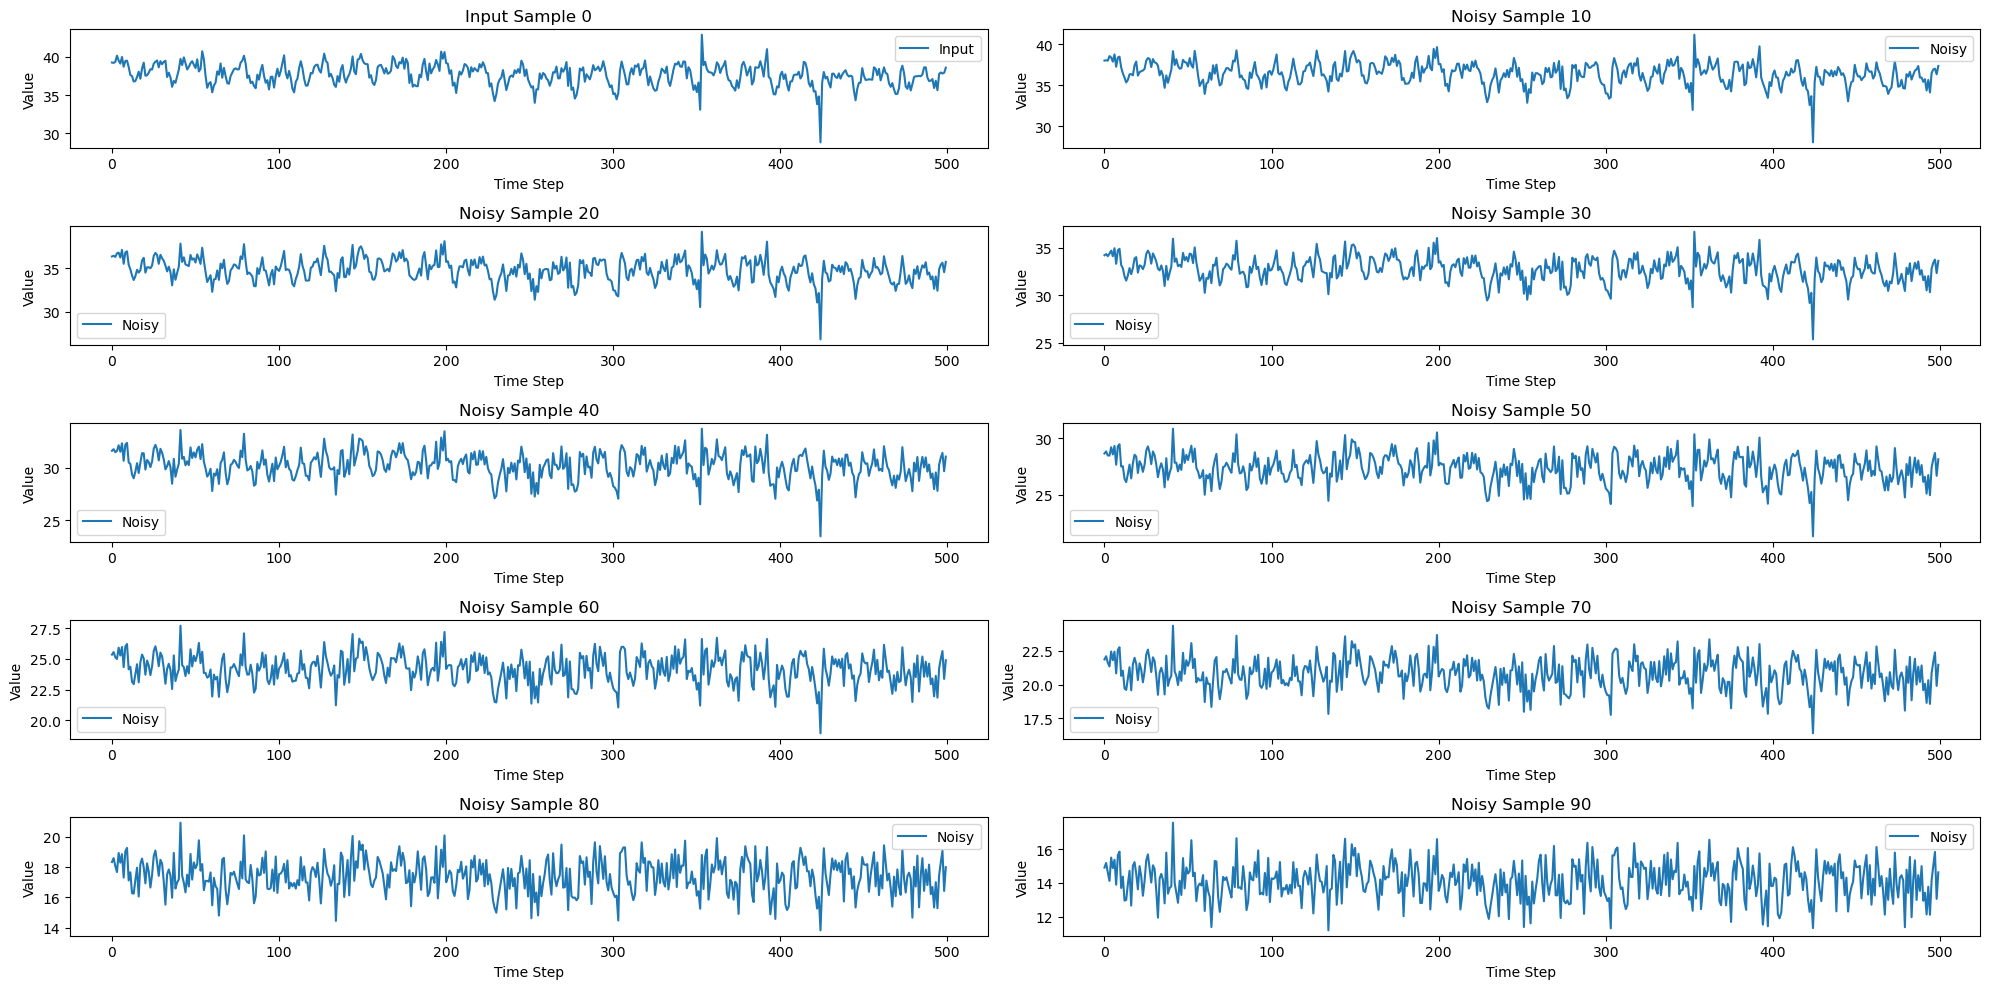

Showing input and noisy data


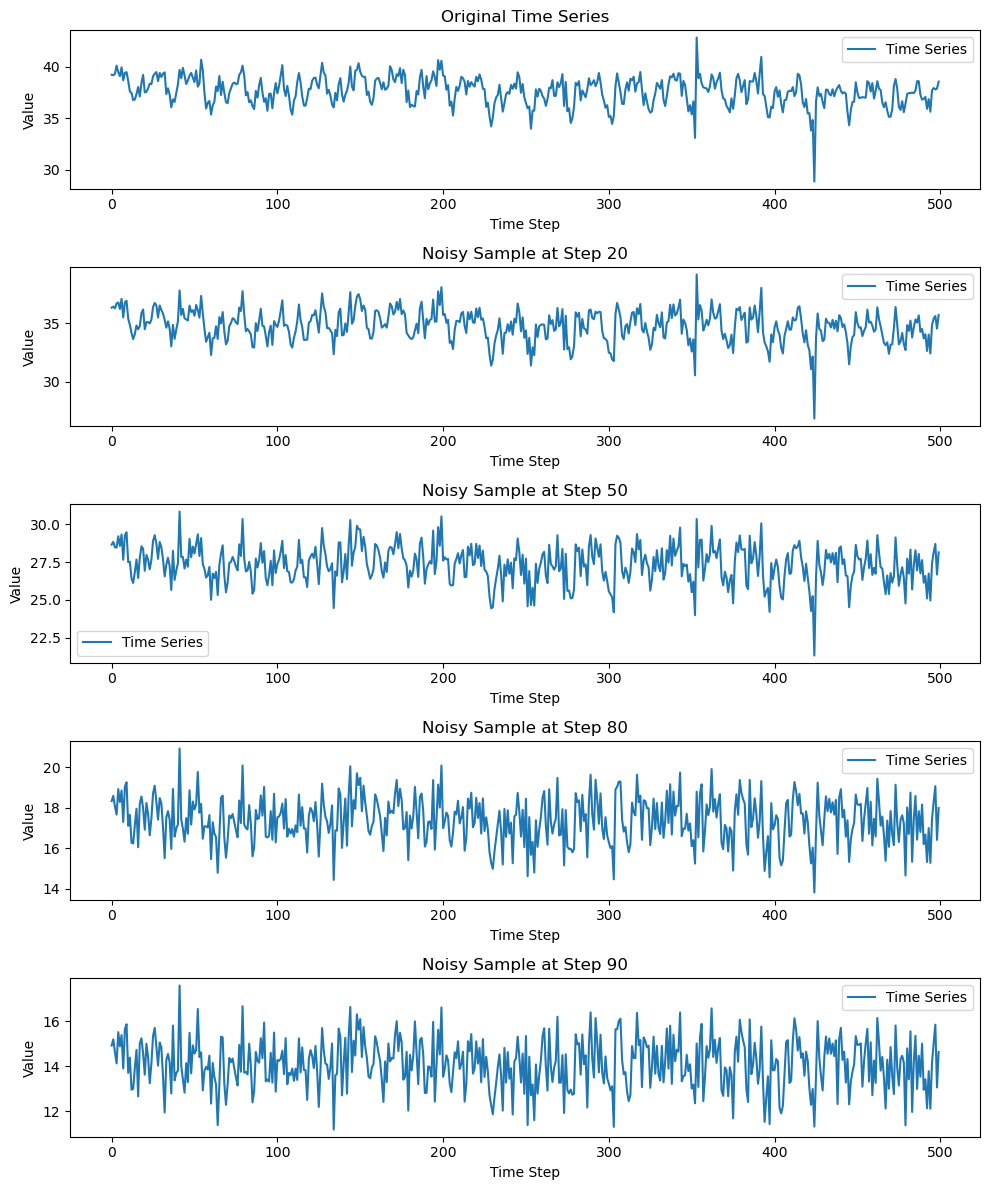

Epoch 0:   0%|          | 0/231 [00:00<?, ?it/s]

Showing original and noisy data


In [107]:

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,  labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        std_batch = batch.std(dim=1, keepdim=True)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = torch.randn_like(batch) #*std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])


        # Plotting noisy versions of the first sample
        for i in range(9):
            print( noise[0])
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
        

        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 50, 80, 90]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        
        break
    
    progress_bar.close()



# Simplex noise

In [108]:
from noise_scheduler import SimplexNoiseScheduler

Epoch 0:   0%|          | 0/231 [00:00<?, ?it/s]

0
tensor([[39.2343, 39.1917, 39.3222, 40.1250, 39.4852, 39.0966, 39.9607, 38.6899,
         39.4312, 39.4882, 38.6536, 37.6037, 37.4657, 36.7593, 36.8246, 37.3549,
         38.0446, 37.1226, 38.4534, 39.2208, 37.5233, 37.5701, 37.9074, 38.3687,
         38.3218, 39.0891, 39.3380, 39.4951, 38.6102, 39.4045, 39.0166, 39.3290,
         39.4690, 37.3509, 37.9147, 37.3056, 36.0700, 36.8444, 36.5921, 37.4385,
         38.3024, 39.7136, 38.9052, 39.9071, 39.1631, 38.3350, 38.6762, 39.1522,
         39.4172, 38.9458, 38.5196, 39.6461, 38.0737, 38.3994, 40.6991, 39.6675,
         37.5010, 35.9441, 36.5007, 36.6853, 35.3525, 36.2402, 36.6181, 38.0882,
         37.6457, 39.1125, 37.2604, 38.5484, 37.4784, 36.5587, 36.4668, 37.4672,
         37.9074, 38.3625, 38.4815, 38.3317, 38.3638, 39.2299, 39.4758, 40.1243,
         39.1271, 37.2348, 37.5428, 36.5559, 36.7430, 36.1829, 35.8853, 37.6585,
         37.0022, 38.1980, 38.9288, 37.5000, 36.5970, 36.9365, 35.7261, 37.3701,
         37.3995, 35.9692,

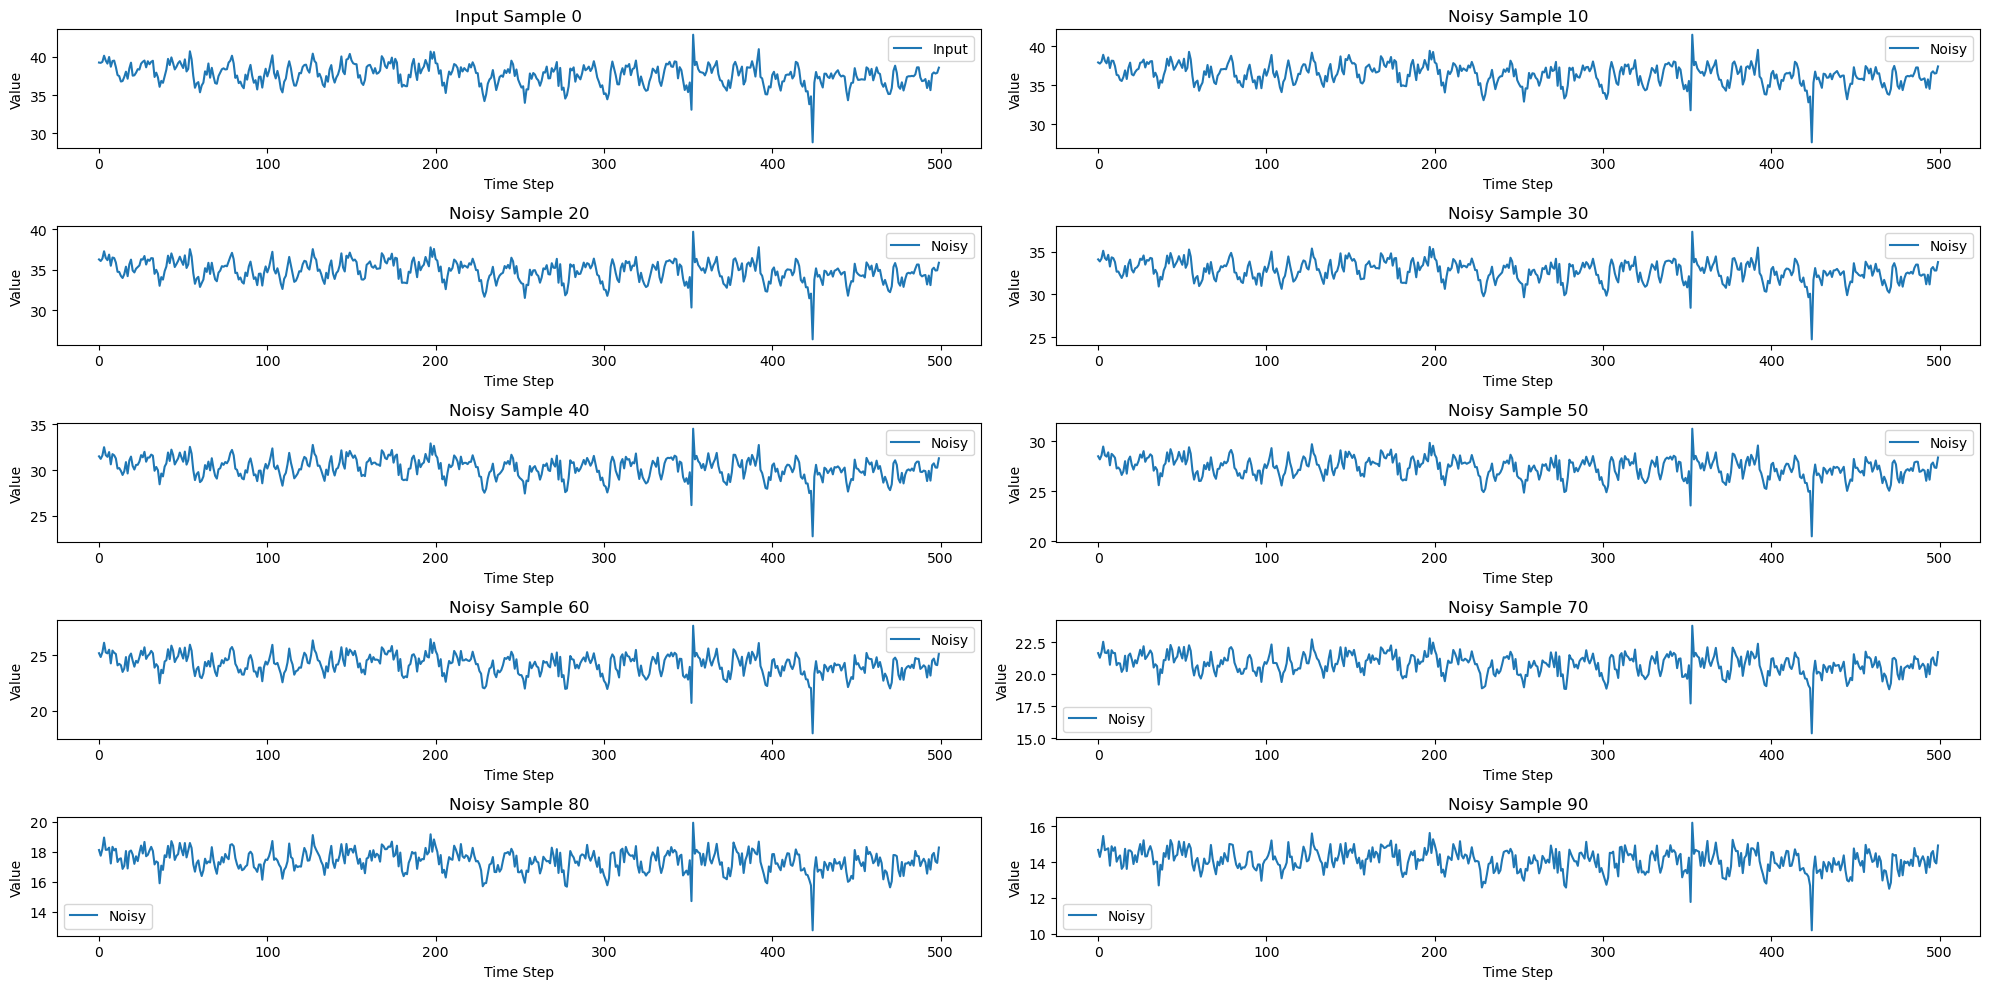

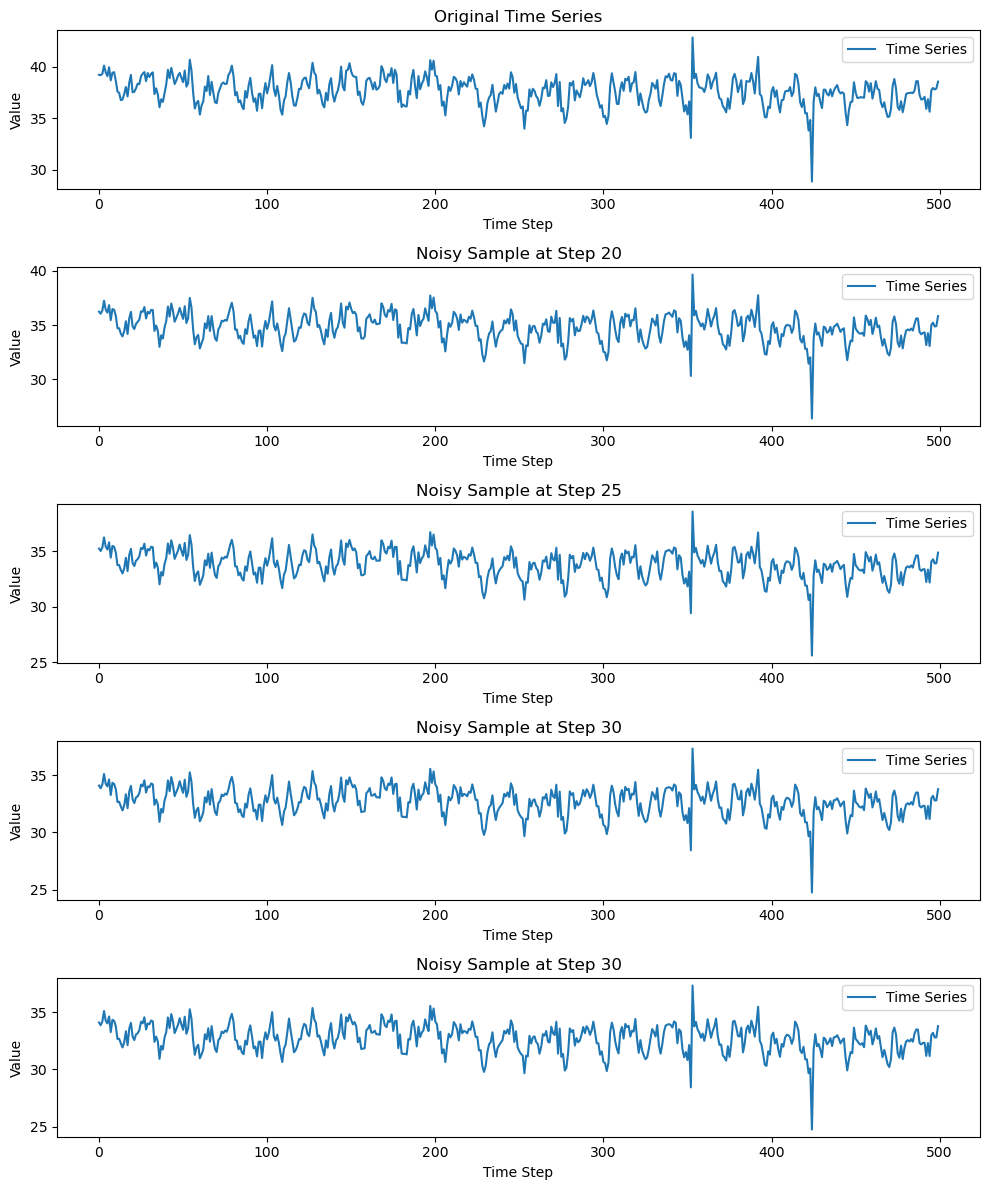

  0%|          | 0/231 [00:00<?, ?it/s]

Showing original and noisy data


In [109]:

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 25, 30, 30]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        break

# Pink noise 

In [110]:
from noise_scheduler import PinkNoiseScheduler

  0%|          | 0/231 [00:00<?, ?it/s]

0
tensor([[39.2343, 39.1917, 39.3222, 40.1250, 39.4852, 39.0966, 39.9607, 38.6899,
         39.4312, 39.4882, 38.6536, 37.6037, 37.4657, 36.7593, 36.8246, 37.3549,
         38.0446, 37.1226, 38.4534, 39.2208, 37.5233, 37.5701, 37.9074, 38.3687,
         38.3218, 39.0891, 39.3380, 39.4951, 38.6102, 39.4045, 39.0166, 39.3290,
         39.4690, 37.3509, 37.9147, 37.3056, 36.0700, 36.8444, 36.5921, 37.4385,
         38.3024, 39.7136, 38.9052, 39.9071, 39.1631, 38.3350, 38.6762, 39.1522,
         39.4172, 38.9458, 38.5196, 39.6461, 38.0737, 38.3994, 40.6991, 39.6675,
         37.5010, 35.9441, 36.5007, 36.6853, 35.3525, 36.2402, 36.6181, 38.0882,
         37.6457, 39.1125, 37.2604, 38.5484, 37.4784, 36.5587, 36.4668, 37.4672,
         37.9074, 38.3625, 38.4815, 38.3317, 38.3638, 39.2299, 39.4758, 40.1243,
         39.1271, 37.2348, 37.5428, 36.5559, 36.7430, 36.1829, 35.8853, 37.6585,
         37.0022, 38.1980, 38.9288, 37.5000, 36.5970, 36.9365, 35.7261, 37.3701,
         37.3995, 35.9692,

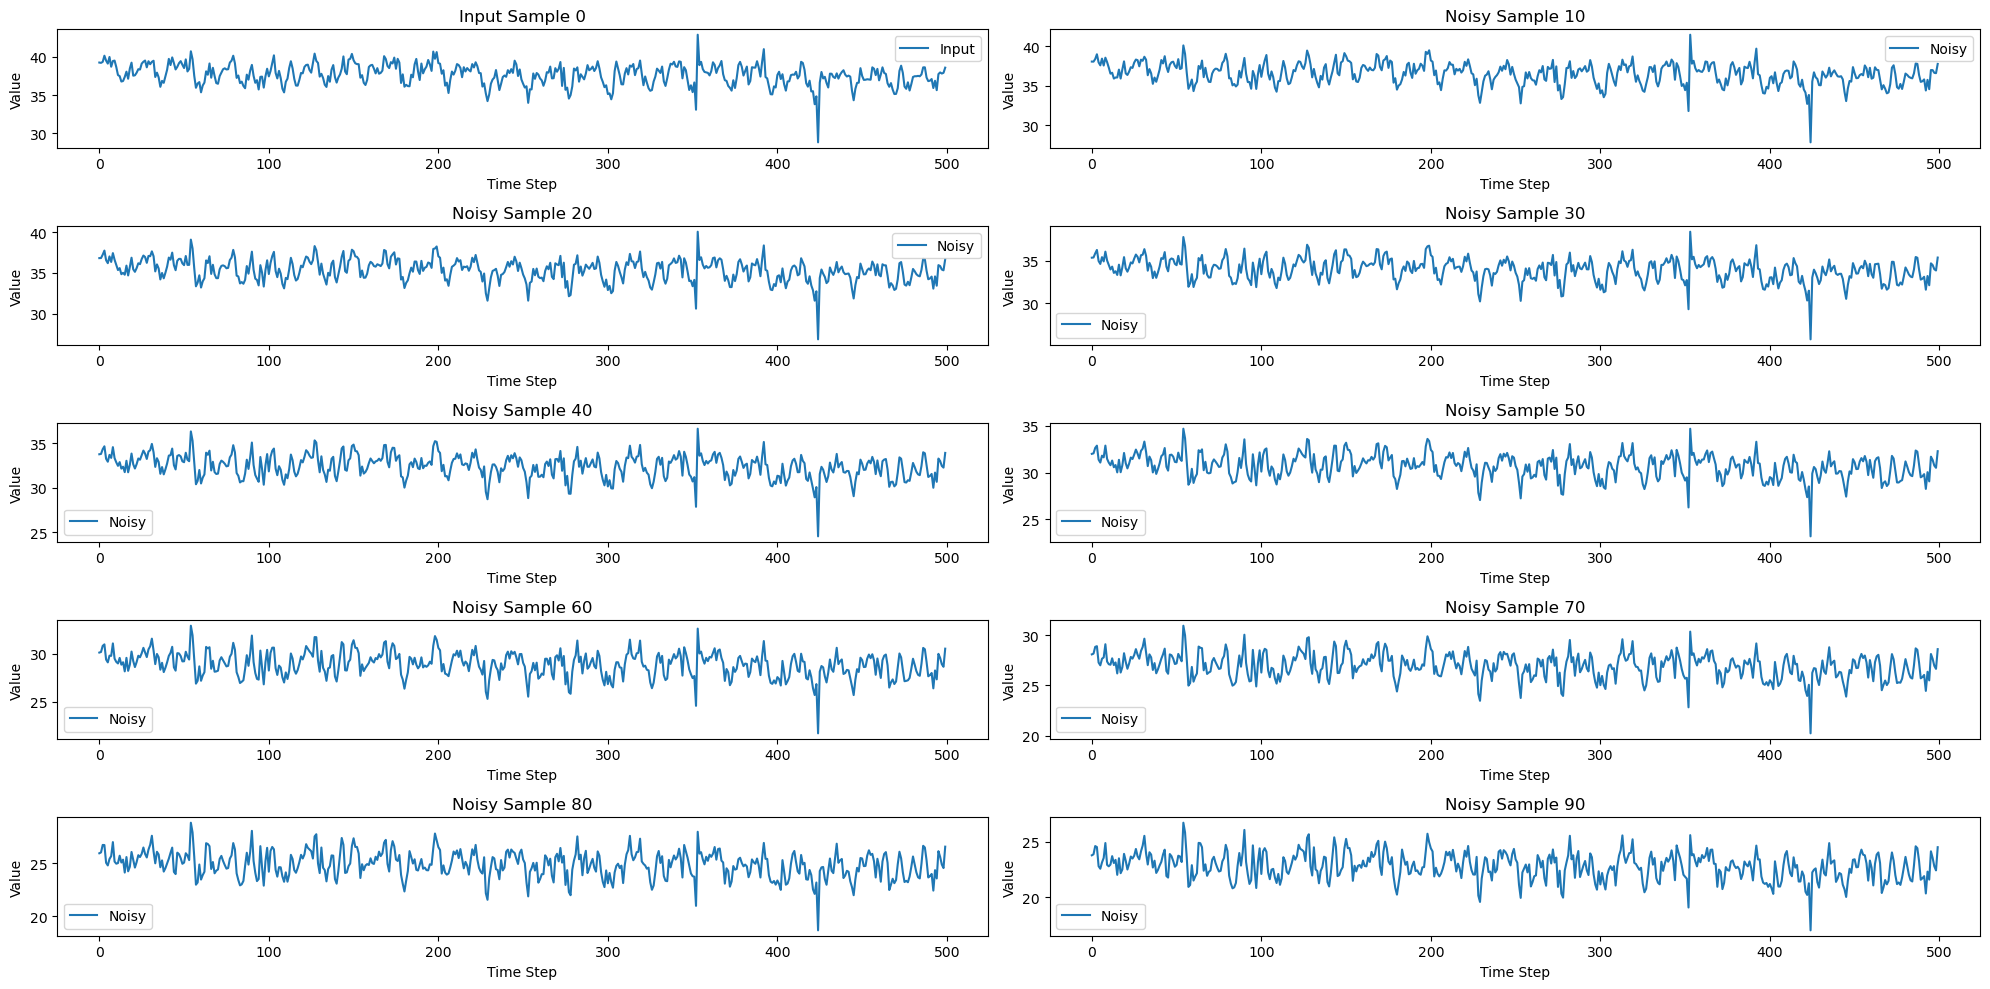

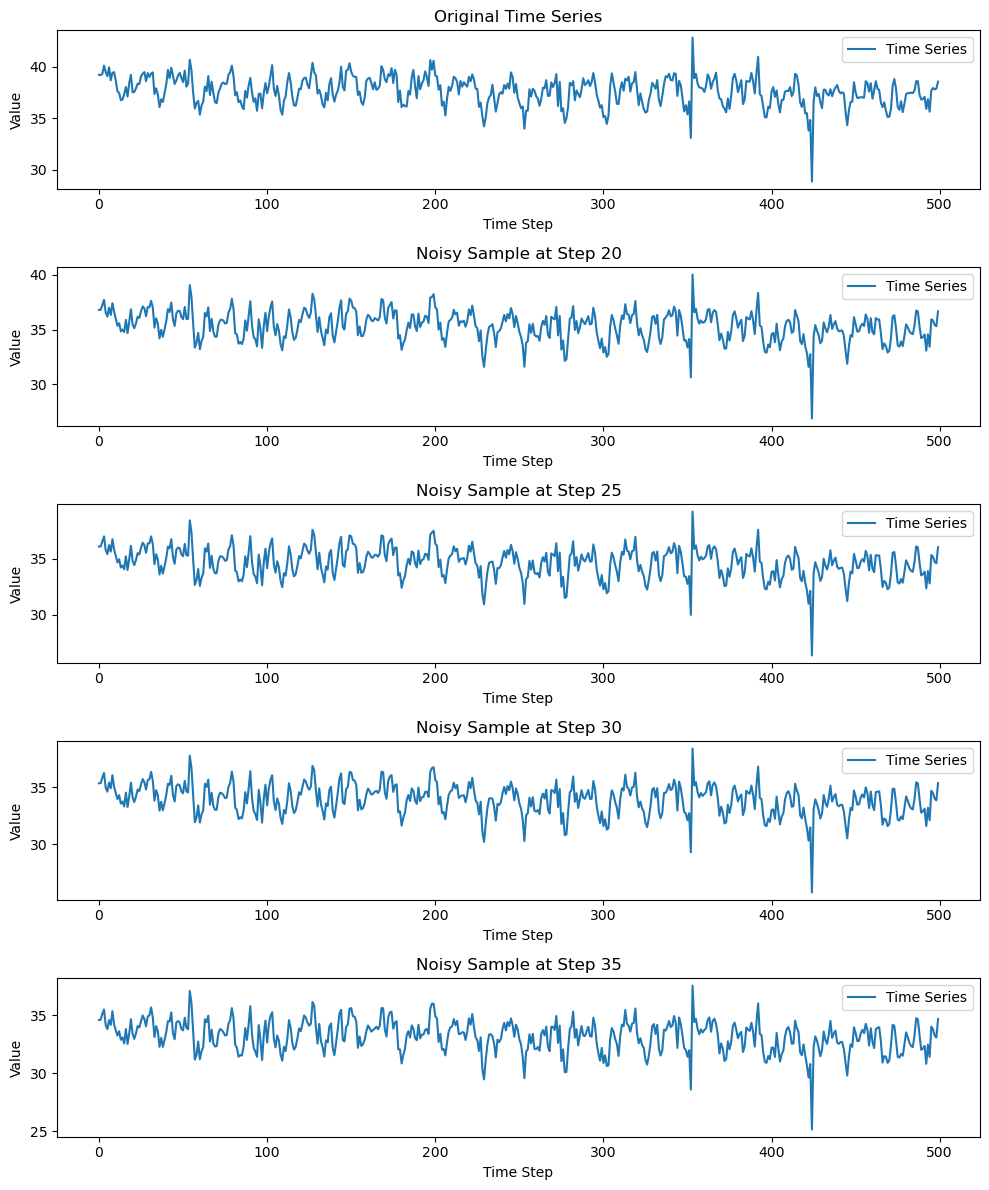

  0%|          | 0/231 [00:00<?, ?it/s]

Showing original and noisy data


In [116]:

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,  labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = noise_scheduler.generate_pink_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 25, 30, 35]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        break